In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
import sys
from pathlib import Path
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
from controlsair import AirProperties, AlgControls#, add_noise, add_noise2
from material import PorousAbsorber
from sources import Source
from receivers import Receiver


# Decomposition
#from zs_array_estimation import ZsArray
#from zs_array_evan import ZsArrayEv
#from decomposition_ev_ig import DecompositionEv2, ZsArrayEvIg, filter_evan
#from scipy.interpolate import griddata
#from decomp_quad_v2 import Decomposition_QDT
#from decomp2mono import Decomposition_2M
from qterm_estimation import ImpedanceDeductionQterm

sys.path.append('D:/Work/dev/scanner_meas/scanner')
sys.path.append('D:/Work/dev/scanner_meas/process_meas')

from ppro_meas_insitu import InsituMeasurementPostPro
from sequential_measurement import ScannerMeasurement
import pytta

In [3]:
pytta.__file__

'C:\\Users\\Cliente\\anaconda3\\envs\\measurement\\lib\\site-packages\\pytta\\__init__.py'

In [5]:
name = 'Melamina_13_06_5_FonteProxima' #'PET_grooved_plate' # 'melamine' #
main_folder = 'D:/Work/UFSM/Pesquisa/insitu_arrays/experimental_dataset/MEAS_JoaoP_GNetto/13_06/'

#name = 'Melamina_17_06_1' #'PET_grooved_plate' # 'melamine' #
#main_folder = 'D:/Work/UFSM/Pesquisa/insitu_arrays/experimental_dataset/MEAS_JoaoP_GNetto/'


# Import data of PET wool

In [6]:
# Intantiate object
ppro_obj = InsituMeasurementPostPro(main_folder = main_folder, name = name)

You probably want to load measurement files that you copied or moved. I'll not create any new folders. Use this object to read only.


In [7]:
ppro_obj.meas_obj.xt.freqMin

50

In [8]:
ppro_obj.meas_obj.receivers.coord

array([[-0.  ,  0.  ,  0.02],
       [-0.  ,  0.  ,  0.04]])

In [5]:
#ppro_obj.meas_obj.receivers.coord[1,2] = 0.02

In [228]:
#ppro_obj.meas_obj.name = 'Melamina_13_06_4_FonteProxima'
#ppro_obj.meas_obj.save()
#ppro_obj.meas_obj.load()


In [9]:
ppro_obj.compute_all_ir_load(regularization = True, only_linear_part = True)

Loading and computing IR for Rec 0
Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.
Saved inside the hdf5 file 1 PyTTa object of 1 object provided.
Loading and computing IR for Rec 1
Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.
Saved inside the hdf5 file 1 PyTTa object of 1 object provided.


In [10]:
# Load all IR
ppro_obj.load_irs()

Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.
Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.


<IPython.core.display.Javascript object>


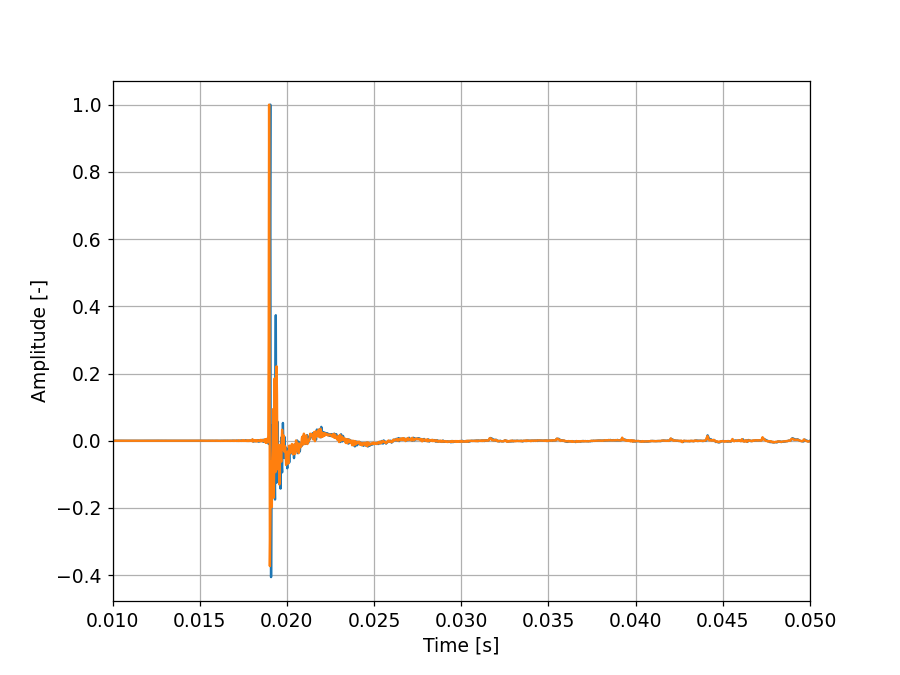

In [22]:
tlims = (0.01, 0.05)
fig, ax = plt.subplots(1, figsize = (8,6), sharex = False)
ppro_obj.plot_ir(ax, idir = 0, normalize = True, xlims = tlims, windowed = False)
ppro_obj.plot_ir(ax, idir = 1, normalize = True, xlims = tlims, windowed = False)
ax.grid()

In [45]:
# Windowing
adrienne = ppro_obj.set_adrienne_win(tstart = 18e-3, dt_fadein = 1e-3, t_cutoff = 30e-3, dt_fadeout = 2e-3)
ppro_obj.apply_window()

<IPython.core.display.Javascript object>


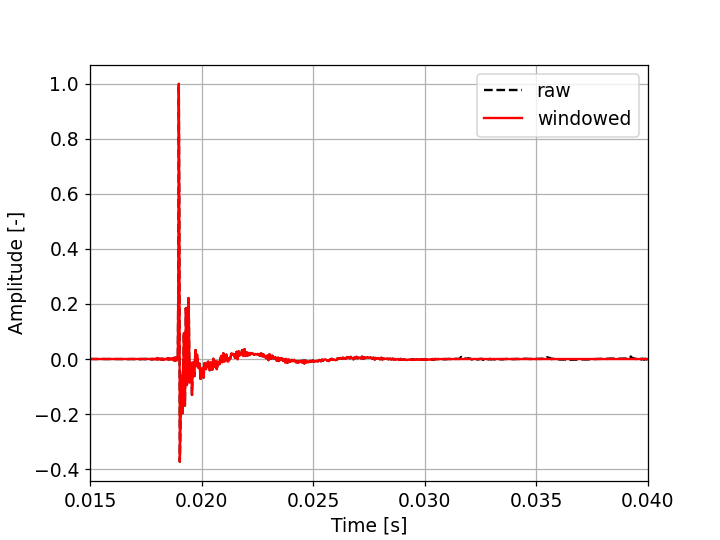

In [46]:
ppro_obj.ir_raw_vs_windowed(idir = 1, xlims = (15e-3, 40e-3))

In [15]:
#ppro_obj.plot_all_ir(figsize = (2,2), figformat = (7,9), normalize = True, xlims = (0, 30e-3),
#                     windowed = False)

<IPython.core.display.Javascript object>


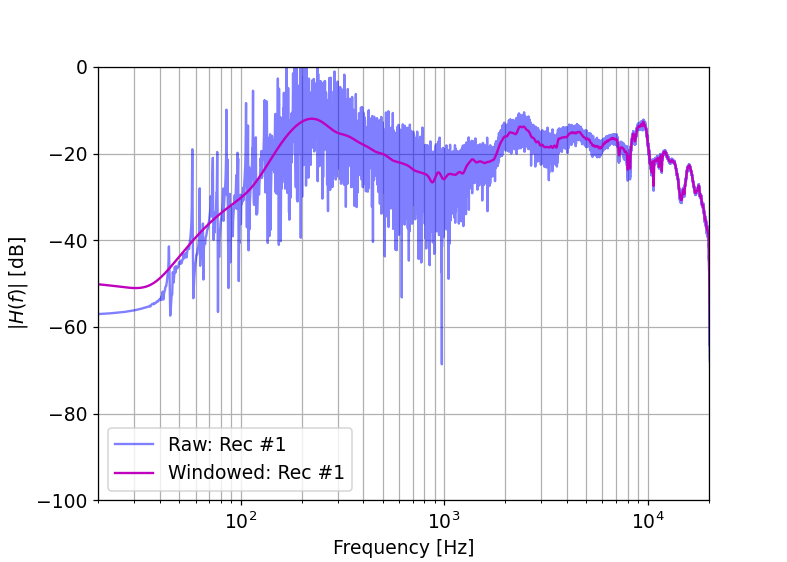

In [47]:
ppro_obj.frf_raw_vs_windowed(idir = 1, ylims = (-100, 0))

### Get new resolution

In [48]:
ppro_obj.reset_freq_resolution(freq_init = 100, freq_end = 4000, delta_freq = 10)

In [49]:
# Air properties and controls
air = AirProperties(c0 = 343.0, rho0 = 1.21,)
controls = AlgControls(c0 = air.c0, freq_vec = ppro_obj.freq_Hw) 

In [50]:
source = Source([0, 0, 1.4])
source = Source([0, 0, 0.3])

In [51]:
h_pp = ImpedanceDeductionQterm(p_mtx=ppro_obj.Hww_mtx, controls=controls, receivers=ppro_obj.meas_obj.receivers, 
                               source=source)
h_pp.pw_pp()
h_pp.pwa_pp()
h_pp.zq_pp(h_pp.Zs_pwa_pp, tol = 1e-6, max_iter = 40);

Calculating the surface impedance (q-term): 100%|██████████| 401/401 [00:33<00:00, 11.83it/s]


<IPython.core.display.Javascript object>


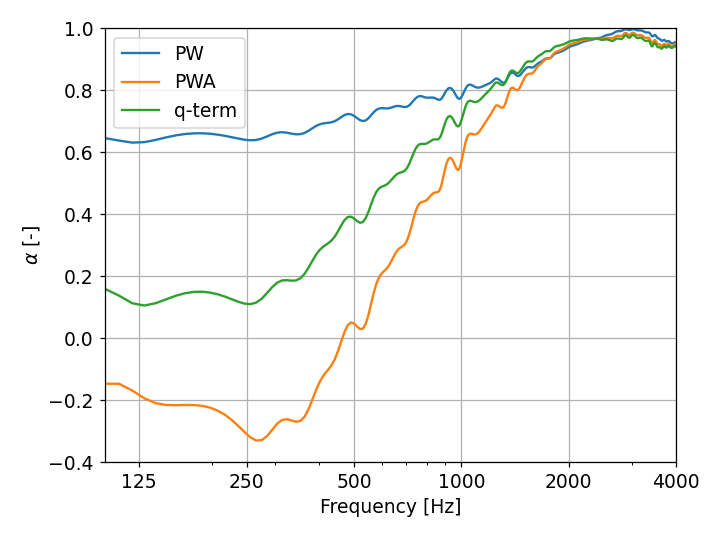

In [52]:
plt.figure()
plt.semilogx(h_pp.controls.freq, h_pp.alpha_pw_pp, label = 'PW')
plt.semilogx(h_pp.controls.freq, h_pp.alpha_pwa_pp, label = 'PWA')
plt.semilogx(h_pp.controls.freq, h_pp.alpha_q_pp, label = 'q-term')
plt.legend()
plt.ylim((-0.4, 1.0))
plt.xlim((100, 4000))
plt.grid()
plt.xticks(ticks = [125,250,500,1000,2000,4000], labels = ['125','250','500','1000','2000','4000'], rotation = 0)
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'$\alpha$ [-]')
plt.tight_layout();

# Load and listen

In [15]:
yt_list = ppro_obj.load_meas_files()

Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.
Imported 1 PyTTa object-like group of 1 group inside the hdf5 file.


<IPython.core.display.Javascript object>


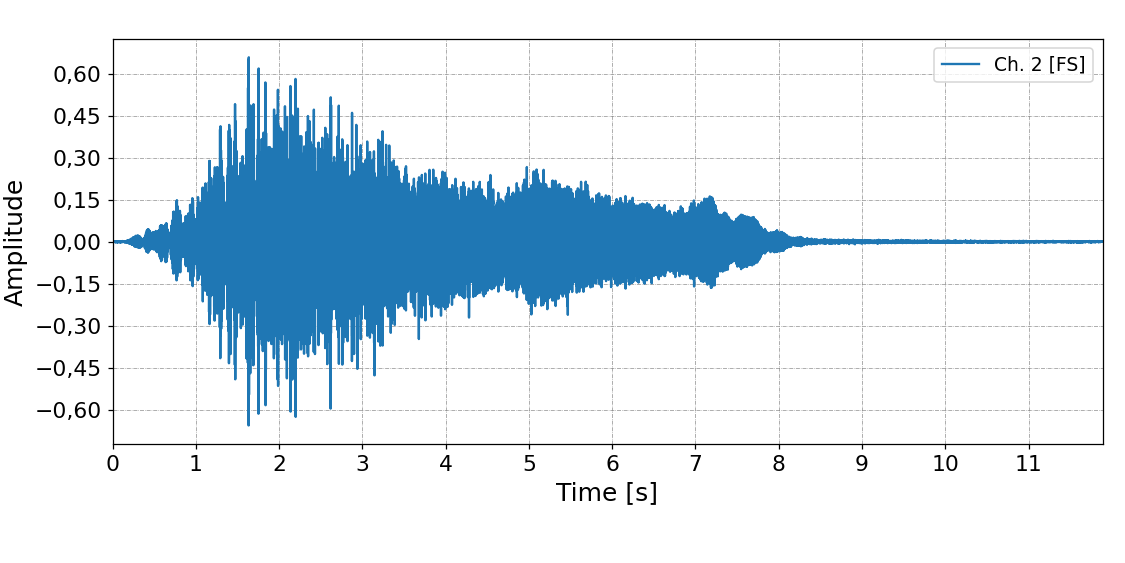

In [16]:
yt_list[0][0].plot_time();

In [19]:
ht = ppro_obj.meas_obj.ir(yt_list[0][0], regularization=True)

<IPython.core.display.Javascript object>


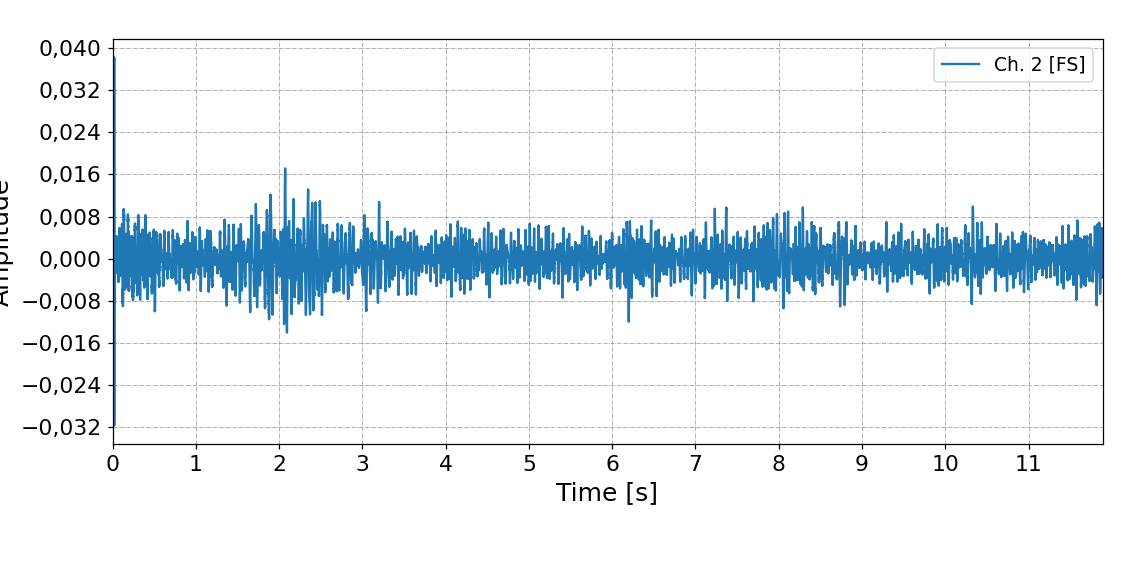

In [20]:
ht.IR.plot_time();

In [138]:
yt_list[1][0].play()

<IPython.core.display.Javascript object>


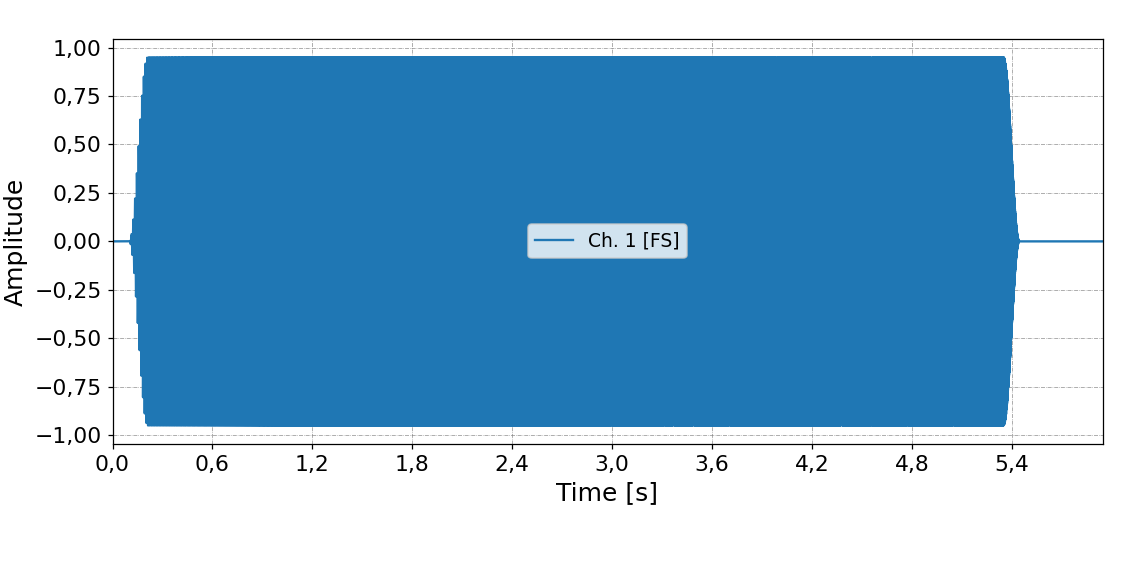

In [9]:
ppro_obj.meas_obj.xt.plot_time();

In [10]:
pytta.save('xt_insitu.hdf5', ppro_obj.meas_obj.xt)

Saved inside the hdf5 file 1 PyTTa object of 1 object provided.


In [62]:
(2**18-1)/44100

5.944285714285714

In [89]:
ppro_obj.meas_obj.xt.samplingRate

44100